In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.stats.api as sms

### Description of the data

In [4]:
#Read the CSV file into a DataFrame
Germany = pd.read_csv('Germany.csv')
# Convert UTC to CET
Germany['Datetime (UTC)'] = pd.to_datetime(Germany['Datetime (UTC)'])
Germany['Datetime (UTC)'] = Germany['Datetime (UTC)'].dt.tz_localize('UTC')
Germany['Datetime (CET)'] = Germany['Datetime (UTC)'].dt.tz_convert('Europe/Berlin')
Germany['Date'] = Germany['Datetime (CET)'].dt.date
Germany.drop(columns=['Datetime (UTC)'], inplace=True)
Germany.drop(columns=['Datetime (CET)'], inplace=True)
Germany.drop(columns=['Datetime (Local)'], inplace=True)
Germany.drop(columns=['ISO3 Code'], inplace=True)


#Read the CSV file into a DataFrame
Energy_data = pd.read_csv('Energy_data.csv')
Energy_data['Capture factor MW Wind Onshore'] = Energy_data['MW Wind Onshore in ct/kwh'] / Energy_data['Baseload in ct/kWh'] 
Energy_data['Capture factor MW Wind Offshore'] = Energy_data['MW Wind Offshore in ct/kwh'] / Energy_data['Baseload in ct/kWh']
Energy_data['Capture factor Solar'] = Energy_data['Solar in ct/kwh'] / Energy_data['Baseload in ct/kWh']

# Convert the 'PDate' column to datetime format
Energy_data['Date'] = pd.to_datetime(Energy_data['Date'])

# Sort the DataFrame by the 'PDate' column in ascending order
Energy_data = Energy_data.sort_values(by='Date')
Energy_data.to_csv('output_file.csv', index=False)
Germany

C:\Users\Bruger\AppData\Local\Temp\ipykernel_14048\2023971864.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Energy_data['Date'] = pd.to_datetime(Energy_data['Date'])


,Country,Price (EUR/MWhe),Date
0,Germany,17.93,2015-01-01
1,Germany,15.17,2015-01-01
2,Germany,16.38,2015-01-01
3,Germany,17.38,2015-01-01
4,Germany,16.38,2015-01-01
...,...,...,...
78883,Germany,7.95,2023-12-31
78884,Germany,6.00,2023-12-31
78885,Germany,10.68,2023-12-31
78886,Germany,2.44,2023-12-31


### Volatility making it staionary 

In [8]:
# Calculate price volatility (standard deviation) for each month and year
Germany['Date'] = pd.to_datetime(Germany['Date'])
Germany['Year'] = Germany['Date'].dt.year
Germany['Month'] = Germany['Date'].dt.month
volatility_by_month_year = Germany.groupby(['Year', 'Month'])['Price (EUR/MWhe)'].std()
volatility_by_month_year = volatility_by_month_year.reset_index()
volatility_by_month_year['Date'] = volatility_by_month_year['Year'].astype(str) + '-' + \
                                    volatility_by_month_year['Month'].astype(str).str.zfill(2) + '-01'
volatility_by_month_year.drop(columns=['Year', 'Month'], inplace=True)
volatility_by_month_year['Price_volatility'] = volatility_by_month_year['Price (EUR/MWhe)']
volatility_by_month_year.drop(columns=['Price (EUR/MWhe)'], inplace=True)
volatility_by_month_year.drop(volatility_by_month_year.index[-1], inplace=True)
volatility_by_month_year['Price_volatility_adj'] = volatility_by_month_year['Price_volatility'].pct_change().dropna()
volatility_by_month_year.dropna(inplace=True)

In [22]:
weighted_volatility

,Date,Price_volatility,Price_volatility_adj
1,2015-02-01,12.551301,-0.058732
2,2015-03-01,12.959160,0.032495
3,2015-04-01,13.224981,0.020512
4,2015-05-01,9.952991,-0.247410
5,2015-06-01,8.589136,-0.137030
...,...,...,...
103,2023-08-01,42.351794,-0.205453
104,2023-09-01,48.391893,0.142617
105,2023-10-01,48.498718,0.002207
106,2023-11-01,42.460743,-0.124498


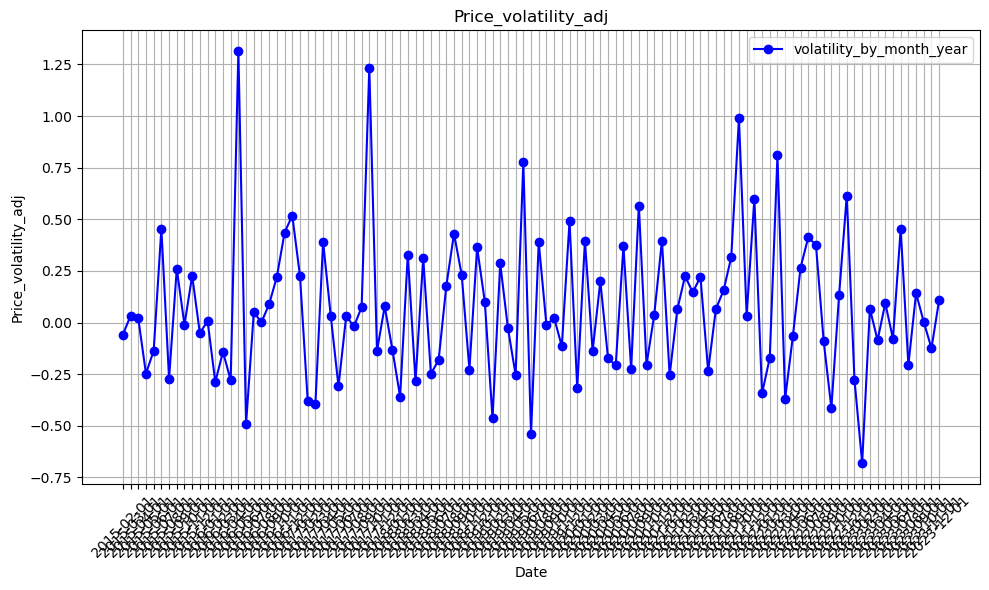

ADF Statistic (Differenced): -13.627593273559553
p-value (Differenced): 1.7480634293020966e-25
Critical Values (Differenced):
	1%: -3.494
	5%: -2.889
	10%: -2.582


In [7]:
plt.figure(figsize=(10, 6))

plt.plot(volatility_by_month_year['Date'], volatility_by_month_year['Price_volatility_adj'], marker='o', color='blue', linestyle='-', label='volatility_by_month_year')

plt.title('Price_volatility_adj')
plt.xlabel('Date')
plt.ylabel('Price_volatility_adj')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Perform Augmented Dickey-Fuller (ADF) test on the differenced data
result_diff = adfuller(volatility_by_month_year['Price_volatility_adj'])

# Print the ADF test results for the differenced data
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])
print('Critical Values (Differenced):')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

### Merge the dataframes

In [9]:
Energy_data['Date'] = pd.to_datetime(Energy_data['Date'])
volatility_by_month_year['Date'] = pd.to_datetime(volatility_by_month_year['Date'])
Power_DATA = pd.merge(Energy_data, volatility_by_month_year, on='Date', how='inner')
Power_DATA.to_csv('output_file.csv', index=False)
Power_DATA

,Date,Baseload in ct/kWh,MW Wind Onshore in ct/kwh,MW Wind Offshore in ct/kwh,Solar in ct/kwh,Capture factor MW Wind Onshore,Capture factor MW Wind Offshore,Capture factor Solar,Price_volatility,Price_volatility_adj
0,2015-02-01,3.672,3.163,3.351,3.678,0.861383,0.912582,1.001634,12.551301,-0.058732
1,2015-03-01,3.134,2.527,2.802,3.059,0.806318,0.894065,0.976069,12.959160,0.032495
2,2015-04-01,2.972,2.536,2.817,2.640,0.853297,0.947847,0.888291,13.224981,0.020512
3,2015-05-01,2.536,2.268,2.400,2.511,0.894322,0.946372,0.990142,9.952991,-0.247410
4,2015-06-01,3.006,2.792,2.859,3.045,0.928809,0.951098,1.012974,8.589136,-0.137030
...,...,...,...,...,...,...,...,...,...,...
102,2023-08-01,9.432,6.613,7.334,7.533,0.701124,0.777566,0.798664,42.351794,-0.205453
103,2023-09-01,10.072,8.566,8.874,7.447,0.850477,0.881056,0.739376,48.391893,0.142617
104,2023-10-01,8.738,6.864,7.426,6.763,0.785534,0.849851,0.773976,48.498718,0.002207
105,2023-11-01,9.112,7.653,7.915,8.525,0.839881,0.868635,0.935579,42.460743,-0.124498


 #### Some simple plots 

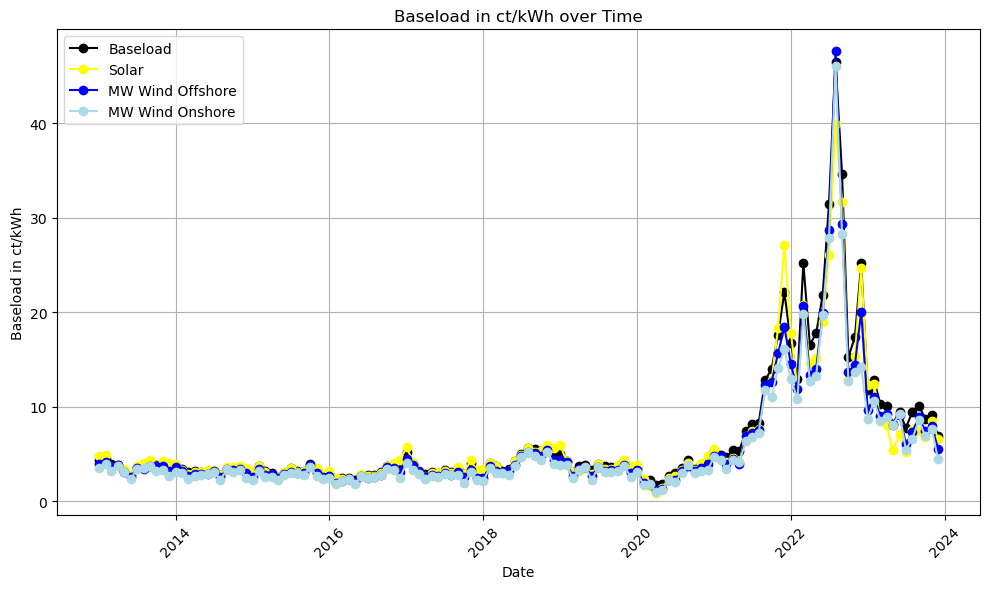

In [10]:
plt.figure(figsize=(10, 6))

plt.plot(Energy_data['Date'], Energy_data['Baseload in ct/kWh'], marker='o', color='black', linestyle='-', label='Baseload')
plt.plot(Energy_data['Date'], Energy_data['Solar in ct/kwh'], marker='o', color='yellow', linestyle='-', label='Solar')
plt.plot(Energy_data['Date'], Energy_data['MW Wind Offshore in ct/kwh'], marker='o', color='blue', linestyle='-', label='MW Wind Offshore')
plt.plot(Energy_data['Date'], Energy_data['MW Wind Onshore in ct/kwh'], marker='o', color='lightblue', linestyle='-', label='MW Wind Onshore')

plt.title('Baseload in ct/kWh over Time')
plt.xlabel('Date')
plt.ylabel('Baseload in ct/kWh')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


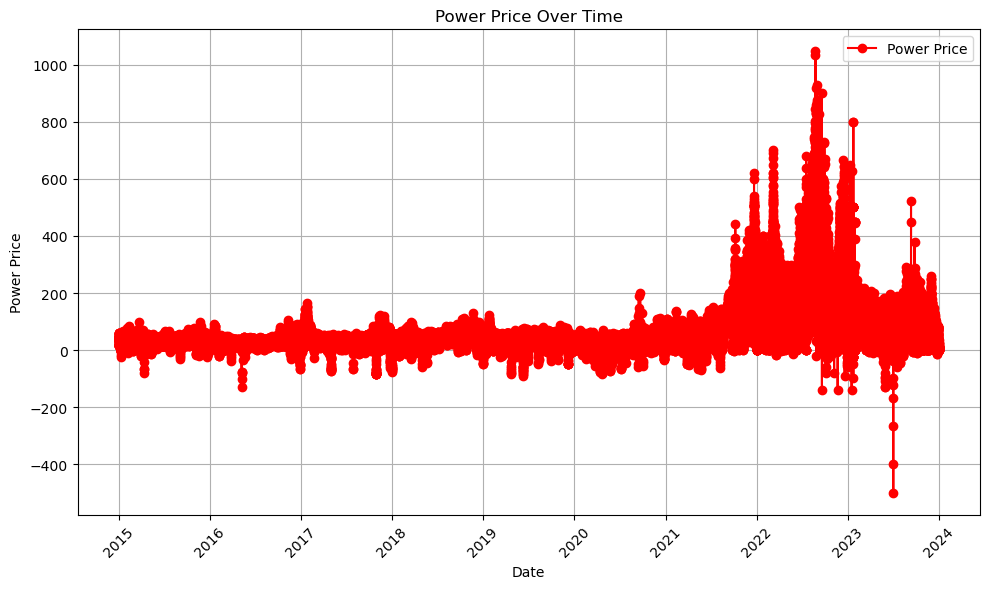

In [11]:
plt.figure(figsize=(10, 6))

# Plot the scatter plot
plt.plot(Germany['Date'], Germany['Price (EUR/MWhe)'], marker='o', color='red', label='Power Price')
plt.title('Power Price Over Time')
plt.xlabel('Date')
plt.ylabel('Power Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


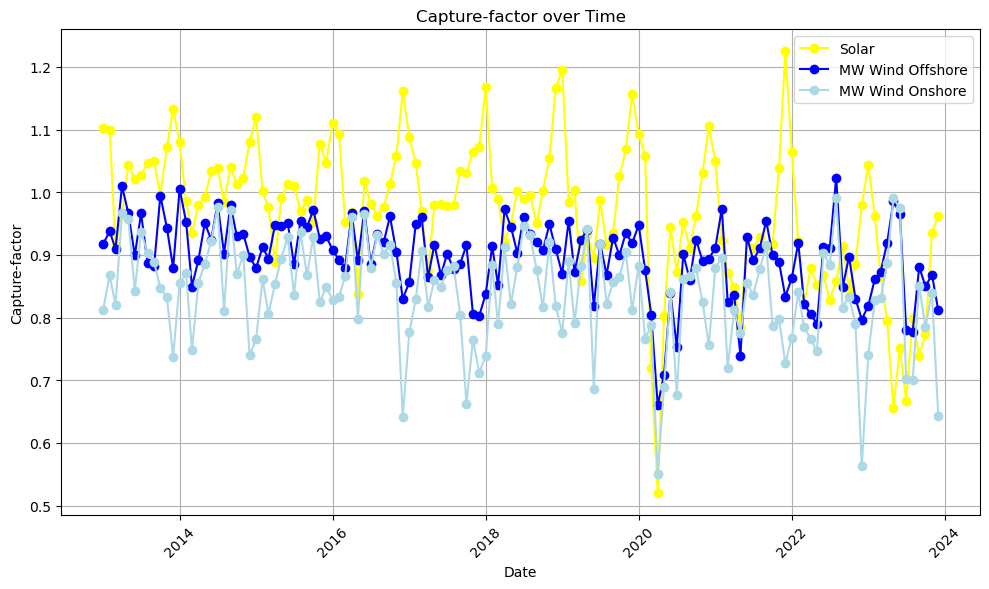

In [18]:
plt.figure(figsize=(10, 6))

plt.plot(Energy_data['Date'], Energy_data['Capture factor Solar'], marker='o', color='yellow', linestyle='-', label='Solar')
plt.plot(Energy_data['Date'], Energy_data['Capture factor MW Wind Offshore'], marker='o', color='blue', linestyle='-', label='MW Wind Offshore')
plt.plot(Energy_data['Date'], Energy_data['Capture factor MW Wind Onshore'] , marker='o', color='lightblue', linestyle='-', label='MW Wind Onshore')

plt.title('Capture-factor over Time')
plt.xlabel('Date')
plt.ylabel('Capture-factor')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

### Empirical analysis

In [12]:
# Define the independent variables including the constant
X = sm.add_constant(Power_DATA['Capture factor MW Wind Offshore'])

# Define the dependent variable
y = Power_DATA['Price_volatility_adj']

# Fit the regression model
model_OLS = sm.OLS(y, X).fit()

# Print the summary of the model
print(model_OLS.summary())

# Get the number of observations and parameters
n = len(y)
k = model_OLS.df_model  # Number of parameters including intercept

# Compute the residual sum of squares
rss = np.sum(model_OLS.resid**2)

# Compute AIC
aic = n * np.log(rss / n) + 2 * k

# Compute BIC
bic = n * np.log(rss / n) + k * np.log(n)

print("AIC:", aic)
print("BIC:", bic)


                             OLS Regression Results                             
Dep. Variable:     Price_volatility_adj   R-squared:                       0.032
Model:                              OLS   Adj. R-squared:                  0.023
Method:                   Least Squares   F-statistic:                     3.454
Date:                  Tue, 20 Feb 2024   Prob (F-statistic):             0.0659
Time:                          15:26:15   Log-Likelihood:                -37.587
No. Observations:                   107   AIC:                             79.17
Df Residuals:                       105   BIC:                             84.52
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

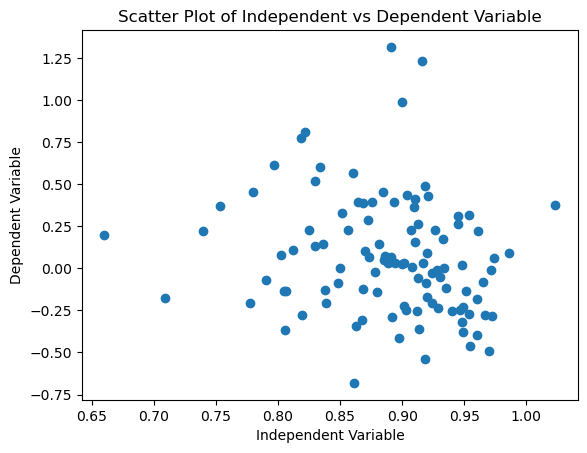

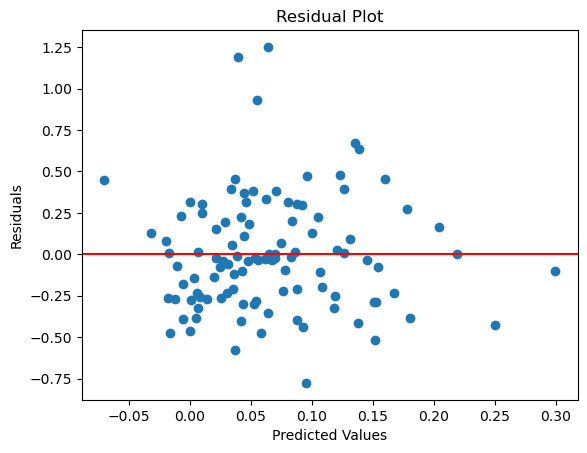

Durbin-Watson statistic: 2.414694871277505


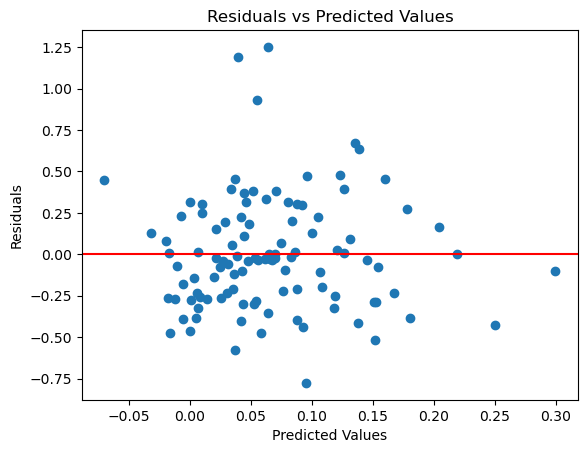

Breusch-Pagan test statistic: 0.04677354007192647, p-value: 0.8287758016669359
Jarque-Bera statistic: 28.630994183090102, p-value: 6.065388275637644e-07


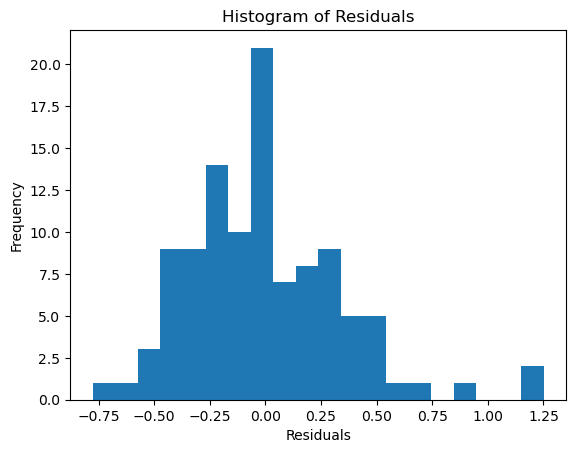

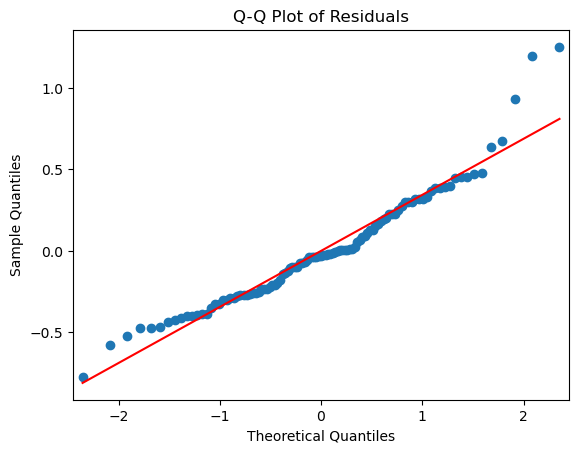

In [13]:
# 1. Check for Linearity
# Scatter plot
plt.scatter(X['Capture factor MW Wind Offshore'], y)
plt.xlabel('Independent Variable')
plt.ylabel('Dependent Variable')
plt.title('Scatter Plot of Independent vs Dependent Variable')
plt.show()

# Residual plot
residuals = model_OLS.resid
plt.scatter(model_OLS.predict(), residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# 2. Test for Independence of Errors
durbin_watson_statistic = sm.stats.stattools.durbin_watson(residuals)
print(f"Durbin-Watson statistic: {durbin_watson_statistic}")

# 3. Assess Homoscedasticity
# Plot of residuals against predicted values
plt.scatter(model_OLS.predict(), residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Breusch-Pagan test
breusch_pagan_test = sms.diagnostic.het_breuschpagan(residuals, X)
print(f"Breusch-Pagan test statistic: {breusch_pagan_test[0]}, p-value: {breusch_pagan_test[1]}")

# 4. Examine Normality of Residuals
# Jarque-Bera test
jarque_bera_statistic, jarque_bera_p_value, skewness, kurtosis = sms.jarque_bera(residuals)
print(f"Jarque-Bera statistic: {jarque_bera_statistic}, p-value: {jarque_bera_p_value}")

# Visual inspection
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Q-Q plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()


In [18]:
# Residuals from the fitted model
residuals = model_OLS.resid

# Design matrix including the constant term
X = model_OLS.model.exog


# Assessing assumptions

# Linearity
rainbow_statistic, rainbow_p_value = sm.stats.diagnostic.linear_rainbow(model_OLS)
print(f"Rainbow statistic: {rainbow_statistic}, p-value: {rainbow_p_value}")

# Independence
durbin_watson_statistic = sm.stats.stattools.durbin_watson(residuals)
print(f"Durbin-Watson statistic: {durbin_watson_statistic}")

# Autocorrelation
# Box-Pierce or Ljung-Box Test
print(f"Ljung-Box statistic:",sms.diagnostic.acorr_ljungbox(residuals))
lb_stat, lb_pvalue = sms.diagnostic.acorr_ljungbox(residuals)
print(f"Ljung-Box statistic: {lb_stat}, p-value: {lb_pvalue}")

# Homoscedasticity
breusch_pagan_test = sms.diagnostic.het_breuschpagan(residuals, X)
print(f"Breusch-Pagan test statistic: {breusch_pagan_test[0]}, p-value: {breusch_pagan_test[1]}")

# Multicollinearity
condition_number = np.linalg.cond(X)
print(f"Condition number: {condition_number}")

# Normality of Residuals
jarque_bera_statistic, jarque_bera_p_value, skewness, kurtosis = sms.jarque_bera(residuals)
print(f"Jarque-Bera statistic: {jarque_bera_statistic}, p-value: {jarque_bera_p_value}")


Rainbow statistic: 1.2849382038830173, p-value: 0.18440076173192463
Durbin-Watson statistic: 2.414694871277505
Ljung-Box statistic:       lb_stat  lb_pvalue
1    4.751287   0.029276
2    4.821089   0.089766
3    5.062847   0.167253
4    7.117357   0.129815
5    8.192559   0.145938
6    8.194982   0.224164
7    9.363205   0.227620
8    9.365668   0.312394
9    9.501787   0.392301
10  11.394289   0.327635
Ljung-Box statistic: lb_stat, p-value: lb_pvalue
Breusch-Pagan test statistic: 0.04677354007192647, p-value: 0.8287758016669359
Condition number: 29.1962742148241
Jarque-Bera statistic: 28.630994183090102, p-value: 6.065388275637644e-07


#### Model

In [67]:
import statsmodels.api as sm

# Add a constant to the independent variable
X = sm.add_constant(Power_DATA['Capture factor MW Wind Offshore'])
y = Power_DATA['Price_volatility_adj']

# Fit the LAD regression model
lad_model = sm.RLM(y, X, M=sm.robust.norms.TukeyBiweight())
lad_results = lad_model.fit()

# Print summary of results
print(lad_results.summary())

# Get the number of observations and parameters
n = len(y)
k = lad_results.df_model  # Number of parameters including intercept

# Compute the residual sum of squares
rss = np.sum(lad_results.resid**2)

# Compute AIC
aic = n * np.log(rss / n) + 2 * k

# Compute BIC
bic = n * np.log(rss / n) + k * np.log(n)

print("AIC:", aic)
print("BIC:", bic)

                     Robust linear Model Regression Results                     
Dep. Variable:     Price_volatility_adj   No. Observations:                  107
Model:                              RLM   Df Residuals:                      105
Method:                            IRLS   Df Model:                            1
Norm:                     TukeyBiweight                                         
Scale Est.:                         mad                                         
Cov Type:                            H1                                         
Date:                  Mon, 19 Feb 2024                                         
Time:                          14:23:13                                         
No. Iterations:                      20                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [70]:
import statsmodels.api as sm

# Add a constant to the independent variable
X = sm.add_constant(Power_DATA['Capture factor MW Wind Offshore'])
y = Power_DATA['Price_volatility_adj']

# Fit the Huber regression model
huber_model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
huber_results = huber_model.fit()

# Print summary of results
print(huber_results.summary())


# Get the number of observations and parameters
n = len(y)
k = huber_results.df_model  # Number of parameters including intercept

# Compute the residual sum of squares
rss = np.sum(huber_results.resid**2)

# Compute AIC
aic = n * np.log(rss / n) + 2 * k

# Compute BIC
bic = n * np.log(rss / n) + k * np.log(n)

print("AIC:", aic)
print("BIC:", bic)


                     Robust linear Model Regression Results                     
Dep. Variable:     Price_volatility_adj   No. Observations:                  107
Model:                              RLM   Df Residuals:                      105
Method:                            IRLS   Df Model:                            1
Norm:                            HuberT                                         
Scale Est.:                         mad                                         
Cov Type:                            H1                                         
Date:                  Mon, 19 Feb 2024                                         
Time:                          14:23:38                                         
No. Iterations:                      13                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

#### Extras 

In [ ]:
# Save DataFrame to CSV
# df.to_csv('output_file.csv', index=False)

# Apply log transformation to the Price_volatility data and First-order differencing
volatility_by_month_year['Log_Price_volatility'] = np.log(volatility_by_month_year['Price_volatility'])
volatility_by_month_year['Diff_Log_Price_volatility'] = volatility_by_month_year['Log_Price_volatility'].diff()

# Remove the first NaN value resulting from differencing
volatility_by_month_year.dropna(inplace=True)

# Perform Augmented Dickey-Fuller (ADF) test on the differenced data
result_diff = adfuller(volatility_by_month_year['Diff_Log_Price_volatility'])

# Print the ADF test results for the differenced data
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])
print('Critical Values (Differenced):')
for key, value in result_diff[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
# Weighted standard deviation
weighted_volatility = Germany.groupby(['Year', 'Month']).apply(
    lambda x: np.sqrt(np.average((x['Price (EUR/MWhe)'] - x['Price (EUR/MWhe)'].mean()) ** 2, weights=x['Load']))
)
weighted_volatility_reset = weighted_volatility.reset_index()
weighted_volatility_reset.columns = ['Year', 'Month', 'Day', 'Weighted_volatility']
weighted_volatility_reset['Date'] = pd.to_datetime(weighted_volatility_reset[['Year', 'Month', 'Day']])
weighted_volatility_reset = weighted_volatility_reset.drop(columns=['Year', 'Month', 'Day'])
weighted_volatility_reset['Date'] = pd.to_datetime(weighted_volatility_reset['Date'])
weighted_volatility_reset['Weighted_volatility_adj'] = weighted_volatility_reset['Weighted_volatility'].pct_change().dropna()
weighted_volatility_reset.dropna(inplace=True)